<a href="https://colab.research.google.com/github/alicetears/thanadolsingkhornart/blob/master/recogset2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import os
import fnmatch
import cv2
import numpy as np
import string
import time
import sys


from keras.preprocessing.sequence import pad_sequences

from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import tensorflow as tf

# ignore warnings in the output
# tf.logging.set_verbosity(tf.logging.ERROR)

from tensorflow.python.client import device_lib

# Check all available devices if GPU is available
# print(device_lib.list_local_devices())
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

import string
# char_list:   'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
# total number of our output classes: len(char_list)
char_list = string.ascii_letters+string.digits + \
    'กขขคฃฆงจฉชซฌญฎฏฐฑฒณดตถทธนบปผฝพฟภมยรฤลฦวศษสหฬอฮ ่้๊๋็ุูึืิี์ัํฯำใไโาๅเแะๆ๑๒๓๔๕๖๗๘๙๐.,!()-$฿'


In [ ]:
len(char_list)

152

In [ ]:
! ls '/content/drive/My Drive/recog/allDataSet'

best_model.hdf5  trains  validations


In [4]:
from skimage import transform

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print(char)

    return dig_lst


Max_char = 90
def read_dataset(path):
    # lists for training dataset
    training_img = []
    training_txt = []
    train_input_length = []
    train_label_length = []
    orig_txt = []

    # lists for validation dataset
    valid_img = []
    valid_txt = []
    valid_input_length = []
    valid_label_length = []
    valid_orig_txt = []

    max_label_len = 0
    all=2733
    i = 1
    flag = 0
    count = 0
    for root, dirnames, filenames in os.walk(path):
        for f_name in fnmatch.filter(filenames, '*.jpg'):
            sys.stdout.write('\r'+str(count/all*100)+'%')
            sys.stdout.flush()
            #if count==all:
              #filename = 'myfile.wav'
              #wave_obj = sa.WaveObject.from_wave_file(filename)
              #play_obj = wave_obj.play()
              #play_obj.wait_done()
            count += 1
            # read input image and convert into gray scale image
            img = cv2.cvtColor(cv2.imread(
                os.path.join(root, f_name)), cv2.COLOR_BGR2GRAY)

            # convert each image of shape (32, 128, 1)
            img = transform.resize(img, (32, int(128/31*Max_char)))

            # get the text from the image
            dtxt = f_name.split('.jpg')[0]
            txt = dtxt.split('_')[1]
            #print('\t'+txt+'\t'+f_name)

            # compute maximum length of the text
            if len(txt) > max_label_len:
                max_label_len = len(txt)

            # split the 150000 data into validation and training dataset as 10% and 90% respectively
            #valid_orig_txt.append(txt)
            #valid_label_length.append(len(txt))
            #valid_input_length.append(31)
            #valid_img.append(img)
            #valid_txt.append(encode_to_labels(txt))
            orig_txt.append(txt)
            train_label_length.append(len(txt))
            train_input_length.append(Max_char)
            training_img.append(img)
            training_txt.append(encode_to_labels(txt))
    return orig_txt, training_txt, training_img, train_input_length, train_label_length, max_label_len


In [5]:
orig_txt, training_txt, training_img, train_input_length, train_label_length, max_label_len = read_dataset('/content/drive/My Drive/recognition/set2/train')
valid_orig_txt, valid_txt, valid_img, valid_input_length, valid_label_length, max_label_len = read_dataset('/content/drive/My Drive/recognition/set2/test')

19.978046103183313%

In [ ]:
max_label_len

In [6]:


inputs = Input(shape=(32, int(128/31*Max_char), 1))

# convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
# poolig layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)

conv_2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)

conv_3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool_2)

conv_4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv_3)
# poolig layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)

conv_5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)

conv_6 = Conv2D(512, (3, 3), activation='relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)

conv_7 = Conv2D(512, (2, 2), activation='relu')(pool_6)

squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)

# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(
    LSTM(128, return_sequences=True, dropout=0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2))(blstm_1)

outputs = Dense(len(char_list)+1, activation='softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

# act_model.summary()


labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
 

In [ ]:
labels, outputs

(<tf.Tensor 'the_labels:0' shape=(None, 90) dtype=float32>,
 <tf.Tensor 'dense/truediv:0' shape=(None, 91, 153) dtype=float32>)

In [7]:
act_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 371, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 371, 64)       640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 185, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 185, 128)      73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 92, 128)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 92, 256)        295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 92, 256)       

In [8]:
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
 
 
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
 
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
 
 
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

# model to be used at training time
model = Model(inputs=[inputs, labels, input_length,
                      label_length], outputs=loss_out)

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')
 

In [9]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 371, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 371, 64)  640         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 16, 185, 64)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 185, 128) 73856       max_pooling2d[0][0]              
_______________________________________________________________________________________

In [10]:

filepath='/content/drive/My Drive/recognition/set2/best_model2.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

train_padded_txt = pad_sequences(
    training_txt, maxlen=max_label_len, padding='post', value=len(char_list))
valid_padded_txt = pad_sequences(
    valid_txt, maxlen=max_label_len, padding='post', value=len(char_list))
# input with shape of height=32 and width=128

training_img = np.array(training_img)
train_input_length = np.array(train_input_length)
train_label_length = np.array(train_label_length)

valid_img = np.array(valid_img)
valid_input_length = np.array(valid_input_length)
valid_label_length = np.array(valid_label_length)
#alid_orig_txt = training_txt
#valid_img = training_img

In [ ]:
#nn = (training_img.shape[0]*1)//4
#valid_img = training_img[:nn]
#valid_padded_txt = train_padded_txt[:nn]
#valid_input_length = train_input_length[:nn]
#valid_label_length = train_label_length[:nn]

#training_img = training_img[nn:]
#train_padded_txt = train_padded_txt[nn:]
#train_input_length = train_input_length[nn:]
#train_label_length = train_label_length[nn:]



In [11]:


batch_size = 256
epochs = 1000
history=model.fit(x=[training_img, train_padded_txt, train_input_length, train_label_length], y=np.zeros(len(training_img)), batch_size=batch_size, epochs=epochs,validation_data=([valid_img, valid_padded_txt, valid_input_length, valid_label_length], [np.zeros(len(valid_img))]), verbose=1, callbacks=callbacks_list)

#inputs, labels, input_length,
                      #label_length

Epoch 1/1000
9/9 [==============================] - ETA: 0s - loss: 186.6843
Epoch 00001: val_loss improved from inf to 127.76978, saving model to /content/drive/My Drive/recognition/set2/best_model2.hdf5
9/9 [==============================] - 22s 2s/step - loss: 186.6843 - val_loss: 127.7698
Epoch 2/1000
9/9 [==============================] - ETA: 0s - loss: 118.1779
Epoch 00002: val_loss improved from 127.76978 to 119.56374, saving model to /content/drive/My Drive/recognition/set2/best_model2.hdf5
9/9 [==============================] - 13s 1s/step - loss: 118.1779 - val_loss: 119.5637
Epoch 3/1000
9/9 [==============================] - ETA: 0s - loss: 113.2119
Epoch 00003: val_loss did not improve from 119.56374
9/9 [==============================] - 12s 1s/step - loss: 113.2119 - val_loss: 120.3555
Epoch 4/1000
9/9 [==============================] - ETA: 0s - loss: 110.9064
Epoch 00004: val_loss did not improve from 119.56374
9/9 [==============================] - 12s 1s/step - loss

{'loss': [107.21981048583984, 106.8874740600586], 'val_loss': [107.4009780883789, 108.79151916503906]}


In [12]:


# load the saved best model weights
act_model.load_weights(filepath)

# predict outputs on validation images
prediction = act_model.predict(valid_img)

# use CTC decoder
out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                               greedy=True)[0][0])

# see the results
i = 0
for x in out:
    print("original_text =  ", valid_orig_txt[i])
    print("predicted text = ", end='')
    for p in x:
        if int(p) != -1:
            print(char_list[int(p)], end='')
    print('\n')
    i += 1

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
original_text =   ลดความเหนื่อยล้าด้วย
predicted text = สรควานเนือยล้าลวย

original_text =   มีพระบรมราชโองการ ในพระบาทสมเด็จ
predicted text = มีเรรหามศาฬโองกาง ไเระบสมเตี่ง

original_text =   หัวใจสีดำ
predicted text = หัวใจสีดำ

original_text =   เวลานั้น ไม่มีใครรู้ว่า  ไอ้ด่าง  กินคนไปกี่คนแล้ว
predicted text = เวลานั้น ไม่มีใครร้ว่า  ไอ้ด่าง  ก็ินคนไปที่คนแล้ว

original_text =   ขออนุญาตลูกค้าที่มาทานแล้วนะ
predicted text = ขออนุูญาตลูกค้าที่มาทานแล้วนะ

original_text =   10 นาทีผ่านไป จากเสียงปืนที่ดังเป็นระยะ..เริ่มเงียบ
predicted text = 10 นาทีผ่านไป จากเสียงปืนที่ตด้งเป็นระย..เรืมเงียบ

original_text =   ไม่อาจ
predicted text = ไม่อาจ

original_text =   ยอมรับว่าการปิดถนนปล้นครั้งนี้
predicted text = ยอมรับว่าการปิดถนนปล้นครั้งนี้

original_text =   ฉายา
predicted text = E

original_text =   ผู้กว่้างขวางคนดัง
predicted text = ผู้ กว้างขวางคนดัง

original_text =   แต่นายวิโรจน์ได

dict_keys(['loss', 'val_loss'])


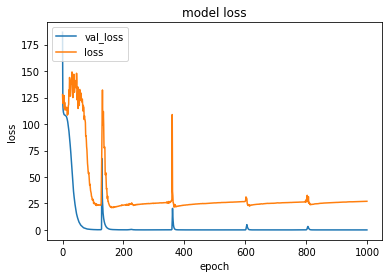

In [13]:
print(history.history.keys())
# Visualize training history
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy

# summarize history for loss
plt.plot(history.history['loss'])
#print(history.history['loss'])
plt.plot(history.history['val_loss'])
#print(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['val_loss', 'loss'], loc='upper left')
plt.show()